In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch
from torch import nn
from torch.utils.data import DataLoader
from src.data.data_synth import ORDataset, ANDDataset, DNFDataset
from src.model.fuzzy.layer import FuzzyOR, FuzzyAND, FuzzyDNF
from src.test.ideal_logic import ORIdealModel, ANDIdealModel
from src.plot import plot_loss, plot_bit_density

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

In [3]:
device = 'cpu'
#device = 'cuda'

In [10]:
def train_dnf(model, dataloader, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.BCELoss()

    seen = 0
    items = []
    obs_losses = []

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        pred = torch.squeeze(model(X))
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)

        # Optimise NN model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        seen += len(X)
        items.append(seen)
        obs_losses.append(loss.item())
        
    return torch.tensor(items), torch.tensor(obs_losses)

  0%|          | 0/1563 [00:00<?, ?it/s]

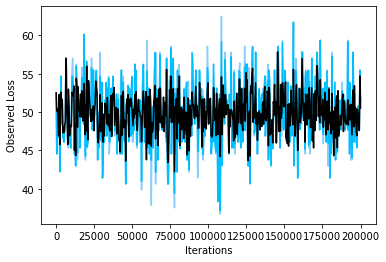

tensor([[ True, False, False, False,  True,  True, False, False,  True, False],
        [False, False,  True, False, False, False, False,  True,  True, False],
        [False, False, False, False, False, False, False, False, False,  True]])
tensor([False, False,  True])
tensor([[1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1.]])


In [13]:
dnf_dim = 5
dnf_dataset = DNFDataset(dnf_dim, 200000, 0.5, 3, 0.3, 0.3)
dnf_dataloader = DataLoader(dnf_dataset, batch_size=128, shuffle=True)

dnf_model = FuzzyDNF(dnf_dim, 1, 3)
dnf_model.to(device)

dnf_items, dnf_losses = train_dnf(dnf_model, dnf_dataloader, lr=1e-1)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
print(dnf_dataset.conj_sets)
print(dnf_dataset.disj_set)
print(dnf_dataset.X)